# Coursera Capstone project week 3 assignment

## Part 1

In [78]:
# Import all libraries
import pandas as pd
import lxml
import folium
import numpy as np
import json
import requests
from sklearn import preprocessing
from sklearn import cluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors
%matplotlib inline

We retrieve the data from the wikipedia page:

In [79]:
# Use the pd.read_html method to retrieve the data
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
list_data = pd.read_html(url)

# The first list item is the data frame of the postal codes
df_base = list_data[0]
# Renaming Column
df_base.rename(columns = {'Neighbourhood': 'Neighborhood'}, inplace = True)
df_base.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [80]:
# Build a new frame with all entries that have a borough assigned
df = df_base[df_base.Borough != 'Not assigned']
# Resetting Index
df.reset_index(inplace = True, drop = True)
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [81]:
# Displaying the shape of the final data frame as well as the number of unique postal codes
print("Shape of the DatFrame: " + str(df.shape))
print("Number of unique postal codes: " + str(df['Postal Code'].nunique()))

Shape of the DatFrame: (103, 3)
Number of unique postal codes: 103


We see that the number of rows in the data frame matches the number of unique postal codes, implying that there are indeed no duplicates.

## Part 2

In [82]:
#Download geographical data
url_geo = 'http://cocl.us/Geospatial_data'
geo_df = pd.read_csv(url_geo)
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [83]:
# Use merge method to build a new data frame that contains the geospatical information
joined_df = pd.merge(df, geo_df, left_on = 'Postal Code', right_on = 'Postal Code')
# Reset Index
joined_df.reset_index(drop = True, inplace = True)
# Show resulting frame and size
print(joined_df.shape)
joined_df.head()

(103, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## Part 3
We will cluster the different postal codes based on the following criteria:\
1) Number of gyms in the area\
2) Number of restaurants in the area\
3) Number of nightlife spots in the area

In [7]:

VERSION = '20180605' # Foursquare API version

We first obtain the different venue categories to get the IDs for all types of gyms, restaurants and nightlife spots. The list can be found here: https://developer.foursquare.com/docs/build-with-foursquare/categories/

In [8]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
CLIENT_ID, CLIENT_SECRET, VERSION)
id_results = requests.get(url).json()

We extract the relevant top-level dictionaries from the overall results.

In [9]:
food_results = id_results['response']['categories'][3]
nightlife_results = id_results['response']['categories'][4]
gym_results = id_results['response']['categories'][5]['categories'][0]['categories'][7]

gym_results

{'id': '4bf58dd8d48988d175941735',
 'name': 'Gym / Fitness Center',
 'pluralName': 'Gyms or Fitness Centers',
 'shortName': 'Gym / Fitness',
 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_',
  'suffix': '.png'},
 'categories': [{'id': '52f2ab2ebcbc57f1066b8b47',
   'name': 'Boxing Gym',
   'pluralName': 'Boxing Gyms',
   'shortName': 'Boxing Gym',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_',
    'suffix': '.png'},
   'categories': []},
  {'id': '503289d391d4c4b30a586d6a',
   'name': 'Climbing Gym',
   'pluralName': 'Climbing Gyms',
   'shortName': 'Climbing Gym',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_',
    'suffix': '.png'},
   'categories': []},
  {'id': '52f2ab2ebcbc57f1066b8b49',
   'name': 'Cycle Studio',
   'pluralName': 'Cycle Studios',
   'shortName': 'Cycle Studio',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/bikeshop_',
    'suffix': '.png'},
   'categories'

The ID dictionaries which we obtained above are nested. We use a recursive function to obtain a dictionary for all IDs that are linked to gyms, restaurants and nightlife sports. The keys represent the category name and the key the category ID.

In [10]:
#Build id dictionaries for the different categories
def extract_id(dictlist):
    id_dict = {}
    if isinstance(dictlist, dict):
        id_dict[dictlist['name']] = dictlist['id']
        dictlist = dictlist['categories']
    for i in range(len(dictlist)):
        id_dict[dictlist[i]['name']] = dictlist[i]['id']
        if dictlist[i]['categories']:
            id_dict.update(extract_id(dictlist[i]['categories']))
    return id_dict

food_ids = extract_id(food_results)
nightlife_ids = extract_id(nightlife_results)
gym_ids = extract_id(gym_results)

gym_ids

{'Gym / Fitness Center': '4bf58dd8d48988d175941735',
 'Boxing Gym': '52f2ab2ebcbc57f1066b8b47',
 'Climbing Gym': '503289d391d4c4b30a586d6a',
 'Cycle Studio': '52f2ab2ebcbc57f1066b8b49',
 'Gym Pool': '4bf58dd8d48988d105941735',
 'Gymnastics Gym': '52f2ab2ebcbc57f1066b8b48',
 'Gym': '4bf58dd8d48988d176941735',
 'Martial Arts Dojo': '4bf58dd8d48988d101941735',
 'Outdoor Gym': '58daa1558bbb0b01f18ec203',
 'Pilates Studio': '5744ccdfe4b0c0459246b4b2',
 'Track': '4bf58dd8d48988d106941735',
 'Weight Loss Center': '590a0744340a5803fd8508c3',
 'Yoga Studio': '4bf58dd8d48988d102941735'}

We now use the search endpoint of the foursquare api to obtain all venues that are within a 2 km radius from the coordinates of each postal code. We store the results in a list called 'results', were each element is a json file for a specific postal code.

In [11]:
radius = 2000
limit = 500
results = []

for i in range(len(joined_df)):
    #Define coordinates
    neighborhood_latitude = joined_df['Latitude'].iloc[i]
    neighborhood_longitude = joined_df['Longitude'].iloc[i]
    
    #Retrieve JSON File
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighborhood_latitude, 
        neighborhood_longitude, 
        radius,
        limit)
    results.append(requests.get(url).json())


Using these results, we count the occurences of restaurants, bars and gyms in the result jsons for each postal code.

In [91]:
result_dict = {}
locs = ['Restaurants', 'Nightlife', 'Gyms',  'Total']
for i in range(len(results)):
    lr = [0, 0, 0, 0]
    lr[3] = len(results[i]['response']['venues'])
    for j in range(len(results[i]['response']['venues'])):
        if results[i]['response']['venues'][j]['categories']:            
            id = results[i]['response']['venues'][j]['categories'][0]['id']
            if id in list(food_ids.values()):
                lr[0] = lr[0] + 1
            elif id in list(nightlife_ids.values()):
                lr[1] = lr[1] + 1
            elif id in list(gym_ids.values()):
                lr[2] = lr[2] + 1
        
    result_dict[joined_df['Postal Code'].iloc[i]] = dict(zip(locs, lr))
        
result_dict

{'M3A': {'Restaurants': 7, 'Nightlife': 2, 'Gyms': 0, 'Total': 92},
 'M4A': {'Restaurants': 11, 'Nightlife': 1, 'Gyms': 1, 'Total': 119},
 'M5A': {'Restaurants': 18, 'Nightlife': 2, 'Gyms': 1, 'Total': 125},
 'M6A': {'Restaurants': 7, 'Nightlife': 1, 'Gyms': 2, 'Total': 124},
 'M7A': {'Restaurants': 9, 'Nightlife': 1, 'Gyms': 0, 'Total': 79},
 'M9A': {'Restaurants': 7, 'Nightlife': 1, 'Gyms': 1, 'Total': 62},
 'M1B': {'Restaurants': 21, 'Nightlife': 1, 'Gyms': 4, 'Total': 122},
 'M3B': {'Restaurants': 11, 'Nightlife': 1, 'Gyms': 3, 'Total': 125},
 'M4B': {'Restaurants': 23, 'Nightlife': 3, 'Gyms': 2, 'Total': 99},
 'M5B': {'Restaurants': 18, 'Nightlife': 1, 'Gyms': 1, 'Total': 121},
 'M6B': {'Restaurants': 27, 'Nightlife': 5, 'Gyms': 4, 'Total': 119},
 'M9B': {'Restaurants': 18, 'Nightlife': 3, 'Gyms': 2, 'Total': 122},
 'M1C': {'Restaurants': 17, 'Nightlife': 2, 'Gyms': 2, 'Total': 120},
 'M3C': {'Restaurants': 17, 'Nightlife': 0, 'Gyms': 4, 'Total': 120},
 'M4C': {'Restaurants': 17, 

We build a DataFrame from the dict

In [84]:
feature_df = pd.DataFrame.from_dict(result_dict).transpose()
feature_df.drop(['Total'], axis = 1, inplace = True)
feature_df.reset_index(inplace = True)
feature_df.rename(columns = {"index" : "Postal Code"}, inplace = True)
feature_df.head()

,Postal Code,Restaurants,Nightlife,Gyms
0,M3A,7,2,0
1,M4A,11,1,1
2,M5A,18,2,1
3,M6A,7,1,2
4,M7A,9,1,0


And now scale the features and use a K Means clustering algorithm to cluster the data into 5 clusters.

In [85]:
#Scaling
feature_norm_df = preprocessing.StandardScaler().fit(feature_df[['Restaurants',  'Nightlife', 'Gyms']]).transform(feature_df[['Restaurants',  'Nightlife', 'Gyms']])

#Cluster object with 5 clusters run with 10 different initializations
k_means_model = cluster.KMeans(n_clusters = 5, init = 'k-means++', n_init = 10)

#Fit the normalized data
k_means_model.fit(feature_norm_df)

#Print labels
labels = k_means_model.labels_
print(labels)

[2 2 2 2 2 2 4 2 1 2 1 1 1 4 1 3 1 1 2 4 1 3 0 1 0 4 0 0 2 4 0 1 2 2 1 3 2
 3 1 2 2 4 0 1 2 2 1 1 0 1 2 1 1 0 1 0 1 2 1 0 0 2 4 0 0 2 4 4 2 2 1 0 2 2
 1 3 4 4 2 0 1 0 0 4 3 2 2 2 1 2 0 2 1 1 1 2 0 0 1 4 2 2 4]


Merge the labels with the original DataFrame

In [86]:
joined_df = pd.merge(joined_df, feature_df, left_on = 'Postal Code', right_on = 'Postal Code')
joined_df['Label'] = labels
joined_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Restaurants,Nightlife,Gyms,Label
0,M3A,North York,Parkwoods,43.753259,-79.329656,7,2,0,2
1,M4A,North York,Victoria Village,43.725882,-79.315572,11,1,1,2
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,18,2,1,2
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,7,1,2,2
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,9,1,0,2


3D scatter plot of the results. The colors represent the cluster label of a data point.

Text(0.5, 0.92, 'Clustering results')

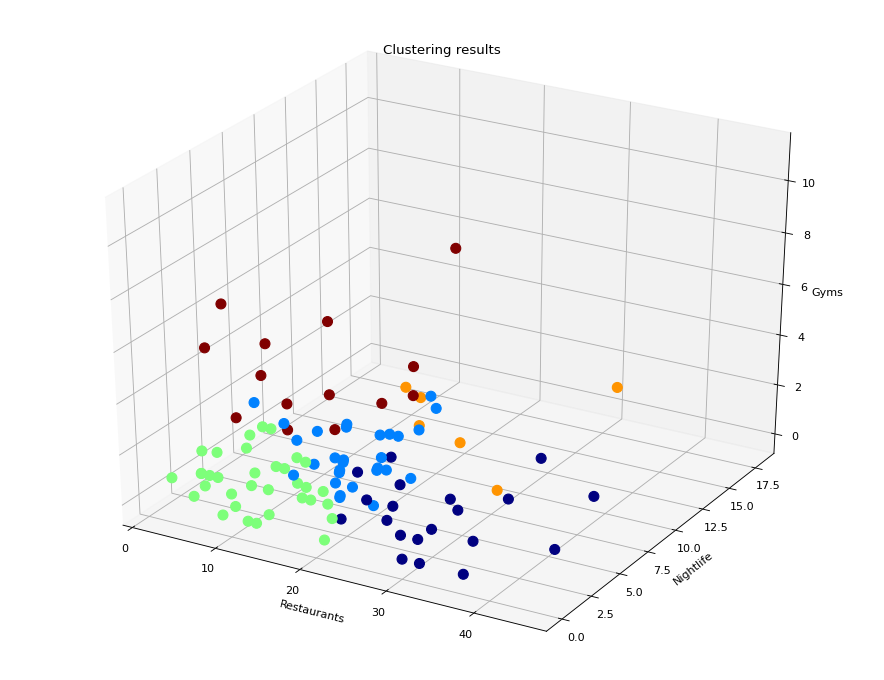

In [87]:
fig = plt.figure(figsize=(14, 11), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')

ax.scatter(joined_df['Restaurants'], joined_df['Nightlife'], joined_df['Gyms'], c = joined_df['Label'],
           cmap = cm.jet, marker = 'o', s = 80, alpha = 1)

ax.set_xlabel('Restaurants')
ax.set_ylabel('Nightlife')
ax.set_zlabel('Gyms')
ax.set_title('Clustering results')

Folium map of the resulting clusters. We use the same colors as in the 3D scatter plot above

In [90]:
#Create Folium Map

cmap = cm.get_cmap('jet', joined_df.Label.nunique())
colorlist = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colorlist.append(matplotlib.colors.rgb2hex(rgb))
    
    
    
m = folium.Map(location = [np.average(joined_df['Latitude']), np.average(joined_df['Longitude'])], 
               zoom_start = 11, control_scale = True)

for i, lat, long in zip(joined_df.index, joined_df['Latitude'], joined_df['Longitude']):
    folium.Circle(
        location = [lat, long],
        radius = 200,
        color = colorlist[joined_df.iloc[i].Label],
        fill = True,
        fill_color = colorlist[joined_df.iloc[i].Label],
        fill_opacity = 1,
        popup = ("Label: "+ str(joined_df.iloc[i].Label))
    ).add_to(m)
m

It is hard to draw conclusions when plotting the clustering results on a map. All of the light blue and light green labels are spread all over the map. The darker blue  and orange label categories tend to cluster more towards the downtown area of Toronto. Looking back at the 3D scatter plots we find that these group generally contains few or no gyms and the largest number of restaurants and in case of the orange labeled cluster the largest amount of nightlife spots. It makes sense that such neighborhoods are more common in the city center. We also find that most of clusters that are labeled red (label 4) have more gyms around them. These neighborhoods are located between the city center and the suburban region. This is possibly due to the fact gyms require a lower retail rent, meaning that they cannot afford to be located in the city center. 